# Objective

#### Classify the given genetic mutations based on clinical evidence provided in the form of text.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm
import time
import warnings
warnings.filterwarnings("ignore")    #This will prevent SettingWithCopyWarning in pandas

# 1. Exploiratory Data Analysis

## 1.1 Reading mutation/variation data

In [2]:
df = pd.read_csv('./Dataset/training_variants')
print('The shape of dataset:', df.shape)
print('List of features:', df.columns.values)

The shape of dataset: (3321, 4)
List of features: ['ID' 'Gene' 'Variation' 'Class']


In [3]:
df.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [5]:
df.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


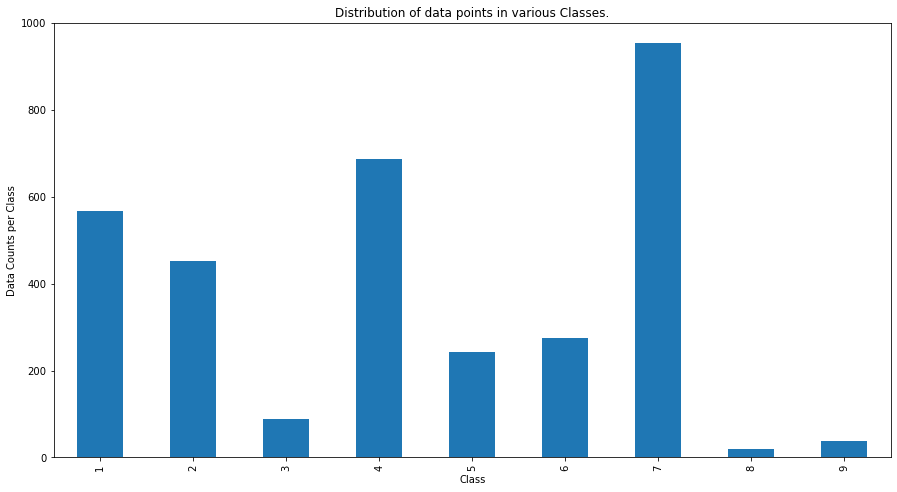

Number of data points in class 7 : 953 ( 28.696 %)
Number of data points in class 4 : 686 ( 20.656 %)
Number of data points in class 1 : 568 ( 17.103 %)
Number of data points in class 2 : 452 ( 13.61 %)
Number of data points in class 6 : 275 ( 8.281 %)
Number of data points in class 5 : 242 ( 7.287 %)
Number of data points in class 3 : 89 ( 2.68 %)
Number of data points in class 9 : 37 ( 1.114 %)
Number of data points in class 8 : 19 ( 0.5720000000000001 %)


In [6]:
df_plot = df['Class'].value_counts().sort_index()

df_plot.plot(kind='bar', figsize=(15,8), title='Distribution of data points in various Classes.')
plt.xlabel('Class')
plt.ylabel('Data Counts per Class')
plt.show()

sorted_yi = np.argsort(-df_plot.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':', df_plot.values[i], '(', np.round((df_plot.values[i]/df.shape[0]*100), 3), '%)')

## 1.2 Reading Text data

In [7]:
df_text = pd.read_csv('./Dataset/training_text', sep='\|\|', engine='python', names=["ID","Text"], skiprows=1)
print('The shape of dataset:', df_text.shape)
print('List of features:', df_text.columns.values)

The shape of dataset: (3321, 2)
List of features: ['ID' 'Text']


Here, while reading the dataset we specified few additional arguments because our training_text data is not actually seperated by comma but by '||' seperator. And our read_csv() method does not identify the seperator and hence we need to make decisions manually.

In [8]:
df_text.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [10]:
df.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


# 2. Preprocessing of data

In [11]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /home/u48988/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Printing the set of stop words present in english language
# You need to download stopword first before using it(import nltk; nltk.download("stopwords");)

stop_words = set(stopwords.words('english'))
print(stop_words)

{'couldn', 'with', 'where', 'yourselves', 'after', 'an', 'll', 's', 't', 'ourselves', "should've", 'below', 'up', 'of', 'in', 'but', 'm', 'through', 'hasn', 'any', 'a', 'into', 'no', 'once', 'i', 'was', "doesn't", "shan't", 'are', 'were', "you've", 'have', 'whom', "mustn't", 'herself', 'then', 'some', 'or', "you'd", 'y', 'as', 'should', 'itself', 'just', 'he', 'because', 'above', 'too', 'theirs', 'mustn', 'that', 'not', 'having', 'doing', 'again', 'other', 'to', 'his', 'under', 'which', "it's", 'these', 'will', 'further', 'ain', 'do', 'aren', "you'll", 'them', 'been', 'don', 'out', "hadn't", 'it', 'why', 'doesn', 'you', "she's", 'ma', 'about', 'there', 've', 'needn', 'him', 'didn', 'most', 'until', 'won', 'your', 'before', 'has', "couldn't", "wouldn't", 'now', 'on', 'so', 'if', "that'll", 'only', 'hers', 'while', 'between', 'more', 'haven', 'off', "isn't", 'what', 'few', 'who', 'can', 'hadn', 'when', 'had', "wasn't", 'this', 'her', 'they', 'nor', 'ours', 'o', 'than', 'each', "hasn't", 

In [13]:
# Core Pre-processing code step-by-step(removing html tags, punctuations, stopwords, etc)

def preprocessing_text(text_data, index):
    if type(text_data) is not int:
        text = ""
        text_data = re.sub('[^A-Za-z0-9]+', ' ', text_data)         #Remove punctuation marks
        text_data = re.sub('\s+', ' ', text_data)                  #Replace multiple spaces with single space
        text_data = text_data.lower()                              #Convert all the text to lowercase
        
        for words in text_data.split():
            if not words in stop_words:
                text += words + " "
        
        df_text['Text'][index] = text

In [14]:
# This may take a few minutes to execute as it needs to execute all the sentences present in data['Text']

initial_time = time.perf_counter()
for index, row in df_text.iterrows():
    if type(row['Text']) is str:
        preprocessing_text(row['Text'], index)
    else:
        print('The ID', index, 'has no text description.')
print('Total time taken for preprocessing:', time.perf_counter() - initial_time, 'seconds.')

The ID 1109 has no text description.
The ID 1277 has no text description.
The ID 1407 has no text description.
The ID 1639 has no text description.
The ID 2755 has no text description.
Total time taken for preprocessing: 28.709448345005512 seconds.


In [15]:
# Since we have two different datasets for training a single model lets merge them into a single dataset

data = pd.merge(df, df_text, on='ID', how='left')
data.head()

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [16]:
# Print all the rows with null values in any field

data[data.isnull().any(axis=1)]

,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [17]:
# Replace null values with  the Gene and Variation name

data.loc[data['Text'].isnull(), 'Text'] = data['Gene'] + ' ' + data['Variation']
data[data['ID'] == 1277]

,ID,Gene,Variation,Class,Text
1277,1277,ARID5B,Truncating Mutations,1,ARID5B Truncating Mutations


# 3. Random splitting of data

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# Splitting data into Train, Test and Cross-validation

X = data
Y = data['Class'].values

x_training, x_test, y_training, y_test= train_test_split(X, Y, test_size=0.2)
x_train, x_cv, y_train, y_cv = train_test_split(x_training, y_training, test_size=0.2)

In [20]:
print("The shape of the training data is:", x_train.shape, y_train.shape)
print("The shape of the CV data is:", x_cv.shape, y_cv.shape)
print("The shape of the test data is:", x_test.shape, y_test.shape)

The shape of the training data is: (2124, 5) (2124,)
The shape of the CV data is: (532, 5) (532,)
The shape of the test data is: (665, 5) (665,)


# 4. Plot Confusion Matrix

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss

In [22]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    recalls =(((C.T)/(C.sum(axis=1))).T)
    precisions =(C/C.sum(axis=0))
    
    labels = [1,2,3,4,5,6,7,8,9]
    
    print("\n\n" + "-"*30, "Confusion matrix", "-"*30 + "\n")
    plt.figure(figsize=(20,8))
    sns.heatmap(C, annot=True, cmap="Blues", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("\n\n" + "-"*30, "Precision matrix (Columm Sum=1)", "-"*30 + "\n")
    plt.figure(figsize=(20,8))
    sns.heatmap(precisions, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("\n\n" + "-"*30, "Recall matrix (Row sum=1)", "-"*30 + "\n")
    plt.figure(figsize=(20,8))
    sns.heatmap(recalls, annot=True, cmap="BuPu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

Log loss on Cross Validation Data using Random Model 2.4596419475713076
Log loss on Test Data using Random Model 2.4650180099726553


------------------------------ Confusion matrix ------------------------------



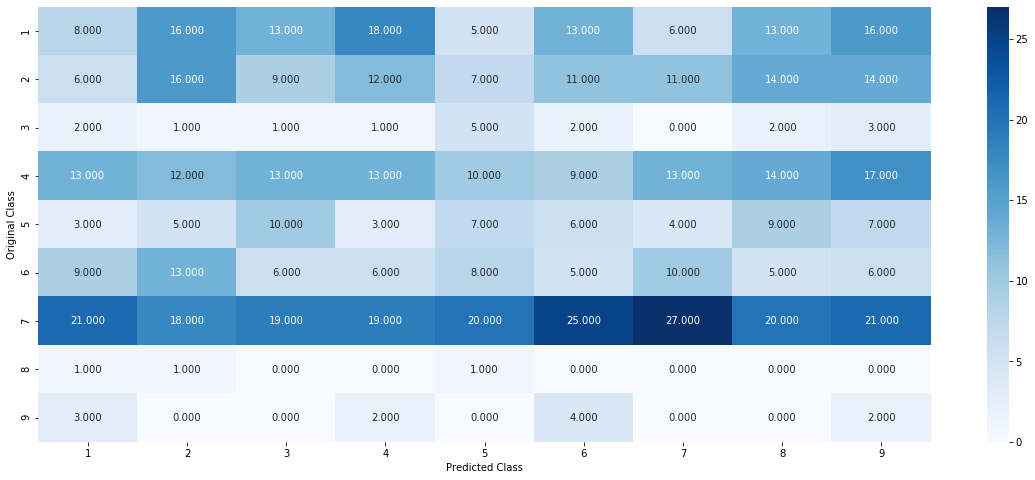



------------------------------ Precision matrix (Columm Sum=1) ------------------------------



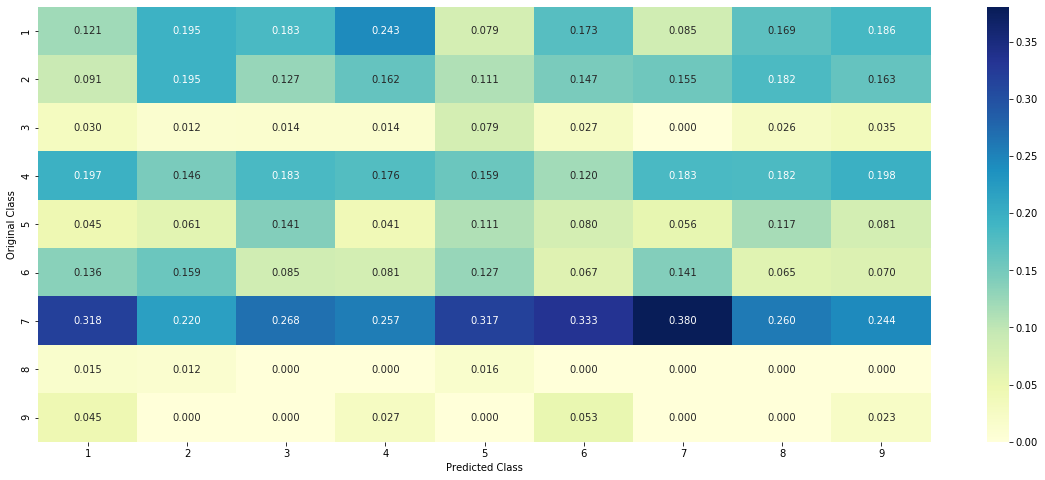



------------------------------ Recall matrix (Row sum=1) ------------------------------



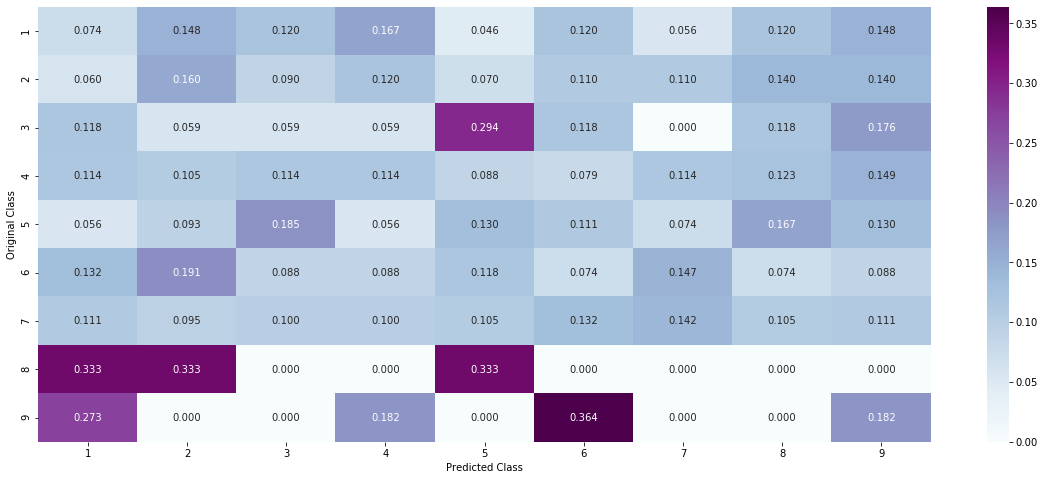

In [23]:
# Genarate 9 numbers and divide each of the numbers by their sum to make the new sum of the numbers 1

test_len = x_test.shape[0]
cv_len = x_cv.shape[0]

# Create an output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_len, 9))
for i in range(cv_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv, cv_predicted_y, eps=1e-15))

# Create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_len, 9))
for i in range(test_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y = np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

Of the total points present in the train data, only 10% (roughly) data points are present in the test and cross-validation data. So the system is unstable. To prevent overfitting of the model, we need to eliminite the Variation Feature.